# Plot spectral mirror plots

load libraries

In [19]:
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import requests
from io import BytesIO
from views_short import *

Specify GNPS job id

In [3]:
GNPSTASK = 'XX'

### plot one spectral mirror plot

In [4]:
clusterindex = '10001'

In [5]:
libraryid = 'CCMSLIB00003137618'

In [6]:
usi1 = 'mzspec:GNPSTASK-' + GNPSTASK + ':spectra/specs_ms.mgf:scan:' + clusterindex

In [7]:
usi2 = 'mzspec:GNPSLIBRARY:' + libraryid

In [8]:
kwargs = {'rescale':False, 'label':True}

Text(0.5, 0.98, '10001:Spectral Match to Penicillamine disulfide from NIST14')

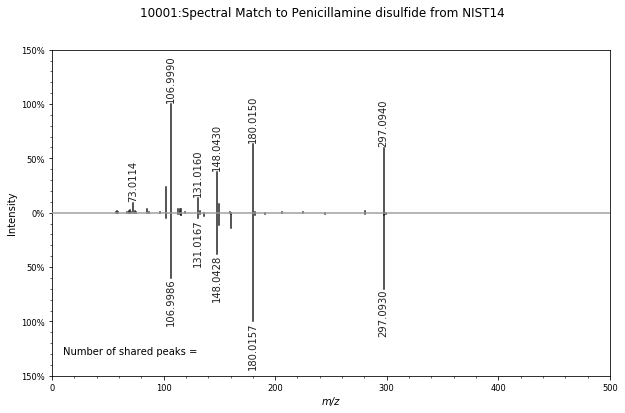

In [9]:
spec1 = prepare_spectrum(usi1, **kwargs)
spec2 = prepare_spectrum(usi2, **kwargs)

fig, ax = plt.subplots(figsize=(10, 6))

spectrum_plotter_plot.mirror(spec1, spec2, ax = ax, spectrum_kws = {'grid':False})

ax.annotate('Number of shared peaks = ',
           xy =(10, -1.3))

xmin, xmax = ax.get_xlim()
ax.set_xlim(kwargs.get('xmin', xmin), kwargs.get('xmax', xmax))
if kwargs.get('label', False):
    ax.set_ylim(-1.5, 1.5)

cnn = parse_gnps_library_compoundname(usi2)

fig.suptitle(f'{clusterindex}:{cnn}', fontsize=12)

### plot several spectral mirror plots

load differential abundance data

In [10]:
diff = pd.read_csv('../Prematurity_SupplementaryMaterial/CorrelationAnalysis/KendallsTauCorrelation_GA.txt', sep = '\t')

In [11]:
diff.head()

,estimate.cor,p.value,p.value.corrected,cluster id
0,0.148333,0.009337,0.066176,1
1,0.138469,0.015240,0.092898,2
2,0.136383,0.016846,0.098614,3
3,0.130313,0.022390,0.117884,4
4,0.042299,0.458521,0.692645,5


load library IDs

In [12]:
libs = pd.read_csv('GNPSLibraryHits.tsv', sep = '\t')

In [14]:
merged_df = pd.merge(libs, diff, left_on='#Scan#', right_on='cluster id', how='left')

In [15]:
merged_df.shape

(206, 40)

In [17]:
sig = merged_df[merged_df['p.value.corrected'] < 0.05]

In [18]:
len(sig)

40

In [20]:
specs1 = []
specs2 = []
cn = []
clindexes = []
sharedpeaks = []
for index, row in sig.iterrows():
    
    clusterindex = str(row['#Scan#'])
    libraryid = row['SpectrumID']
    sharedpeaks.append(row['SharedPeaks'])
    
    usi1 = 'mzspec:GNPSTASK-' + GNPSTASK + ':spectra/specs_ms.mgf:scan:' + clusterindex
    usi2 = 'mzspec:GNPSLIBRARY:' + libraryid
    cn.append(parse_gnps_library_compoundname(usi2))
    clindexes.append(clusterindex)
    
    spec1 = prepare_spectrum(usi1, **kwargs)
    spec2 = prepare_spectrum(usi2, **kwargs)
    
    specs1.append(spec1)
    specs2.append(spec2)

In [21]:
# https://stackoverflow.com/questions/8598163/split-title-of-a-figure-in-matplotlib
def pretty_name(text):
  words = text.split("|")
  words = words[0]
  words = words.split(" ")
  total_string = ""
  for counter, word in enumerate(words):
    if counter>0 and counter % 3 == 0:
      total_string +="\n{}".format(word)
    else:
      total_string +=" {}".format(word)
  return total_string.lstrip()

In [22]:
pretty_name(cn[10])

'Massbank:PR100340 1-Lauroyl-2-hydroxy-sn-glycero-3-phosphocholine'

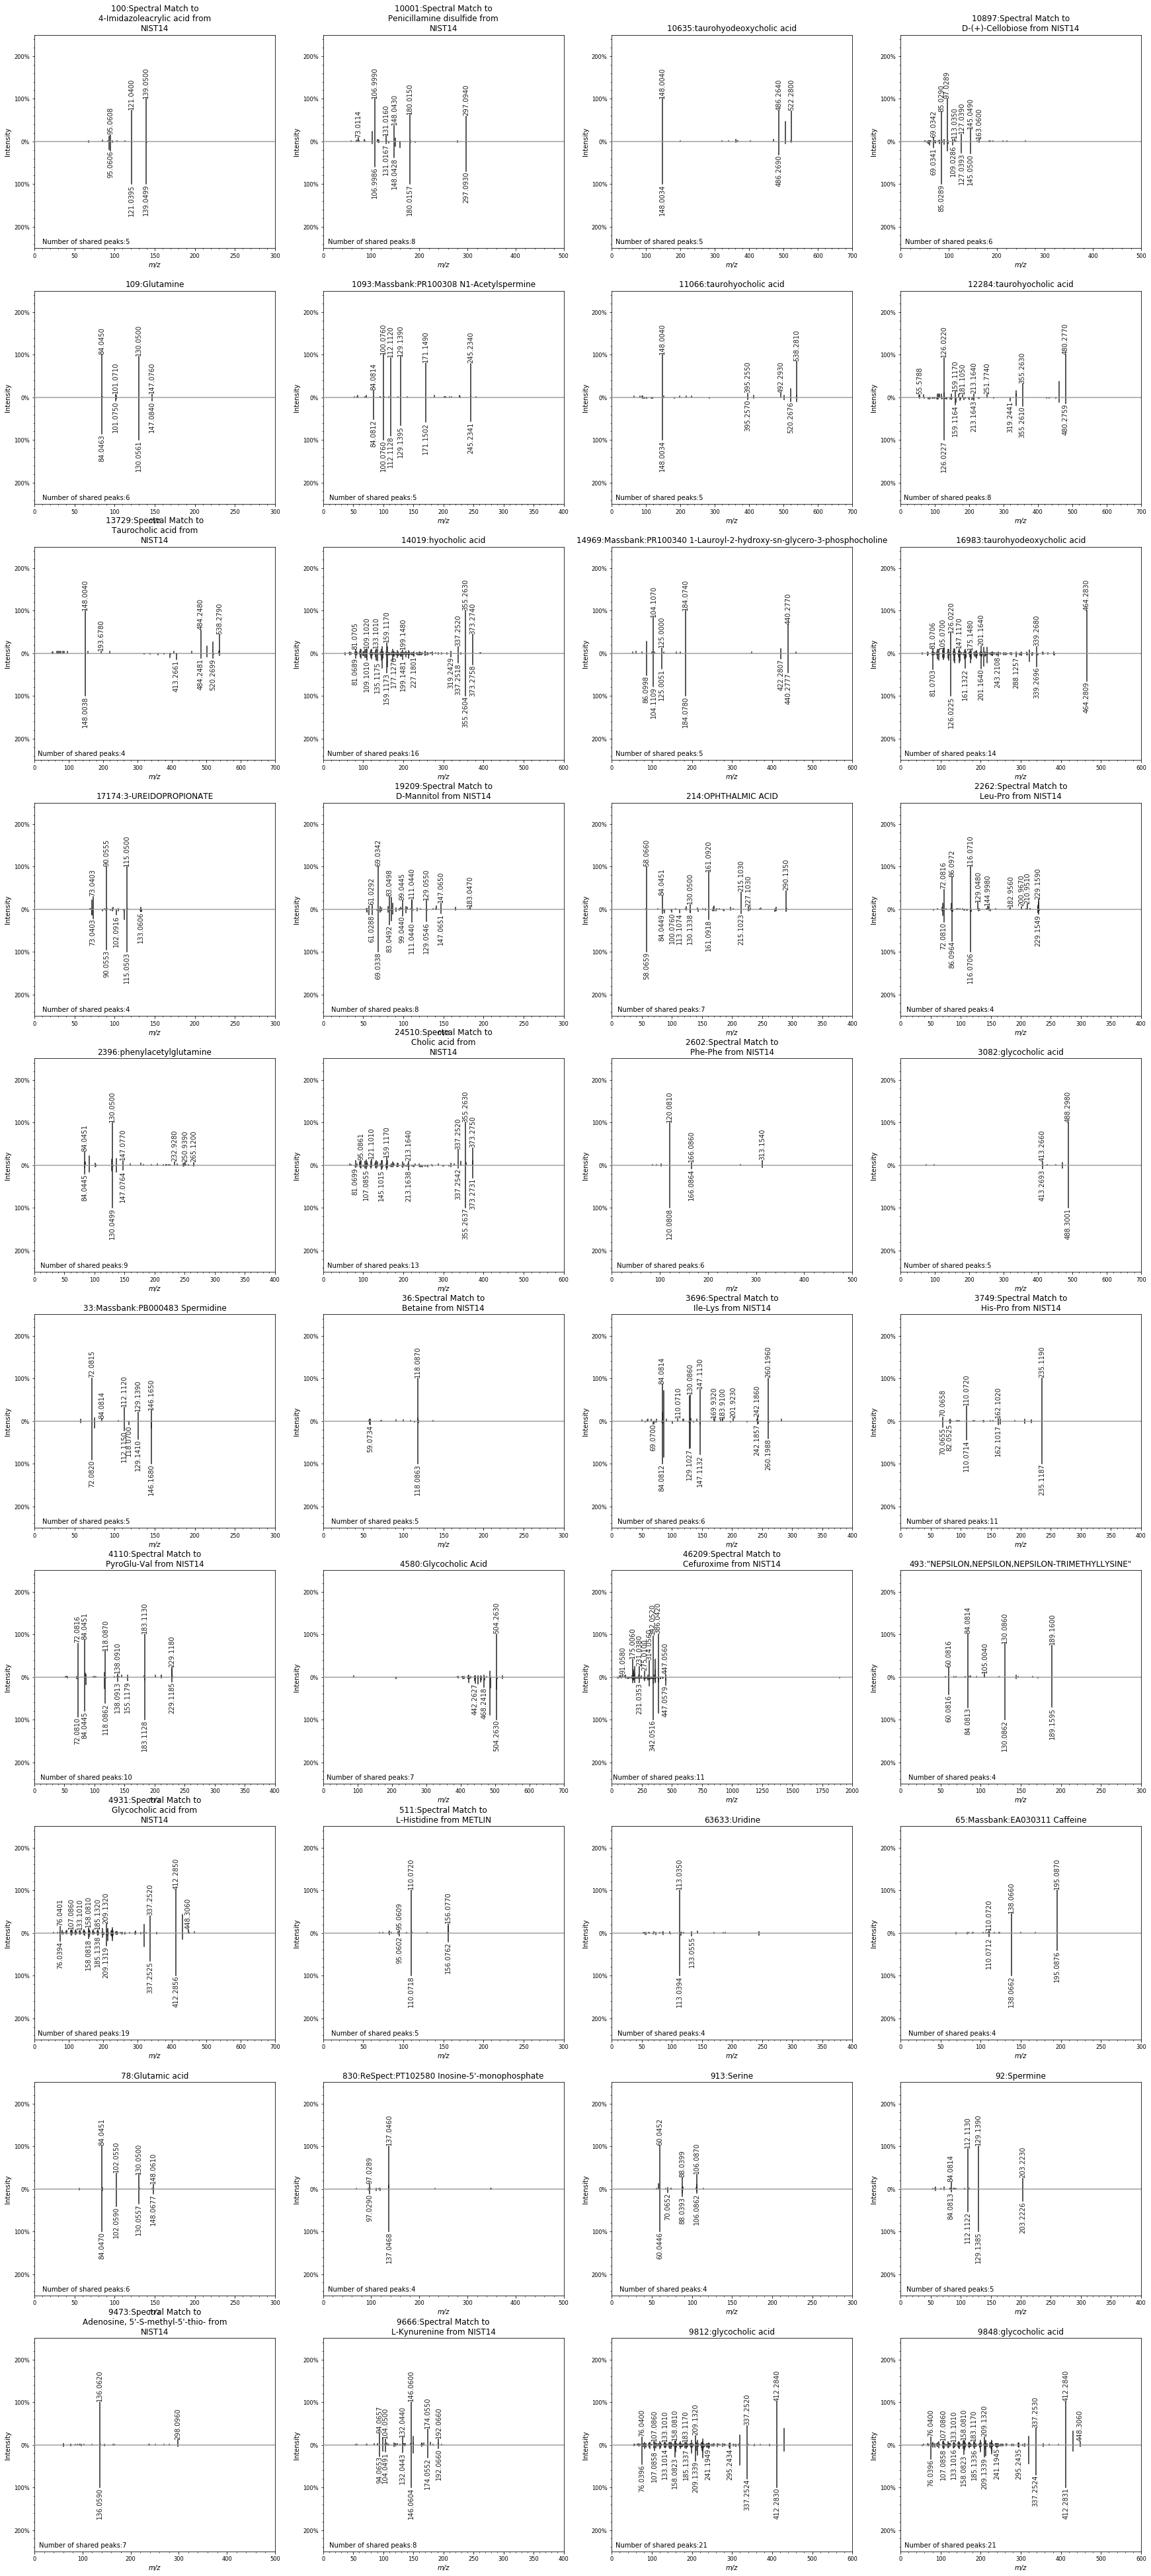

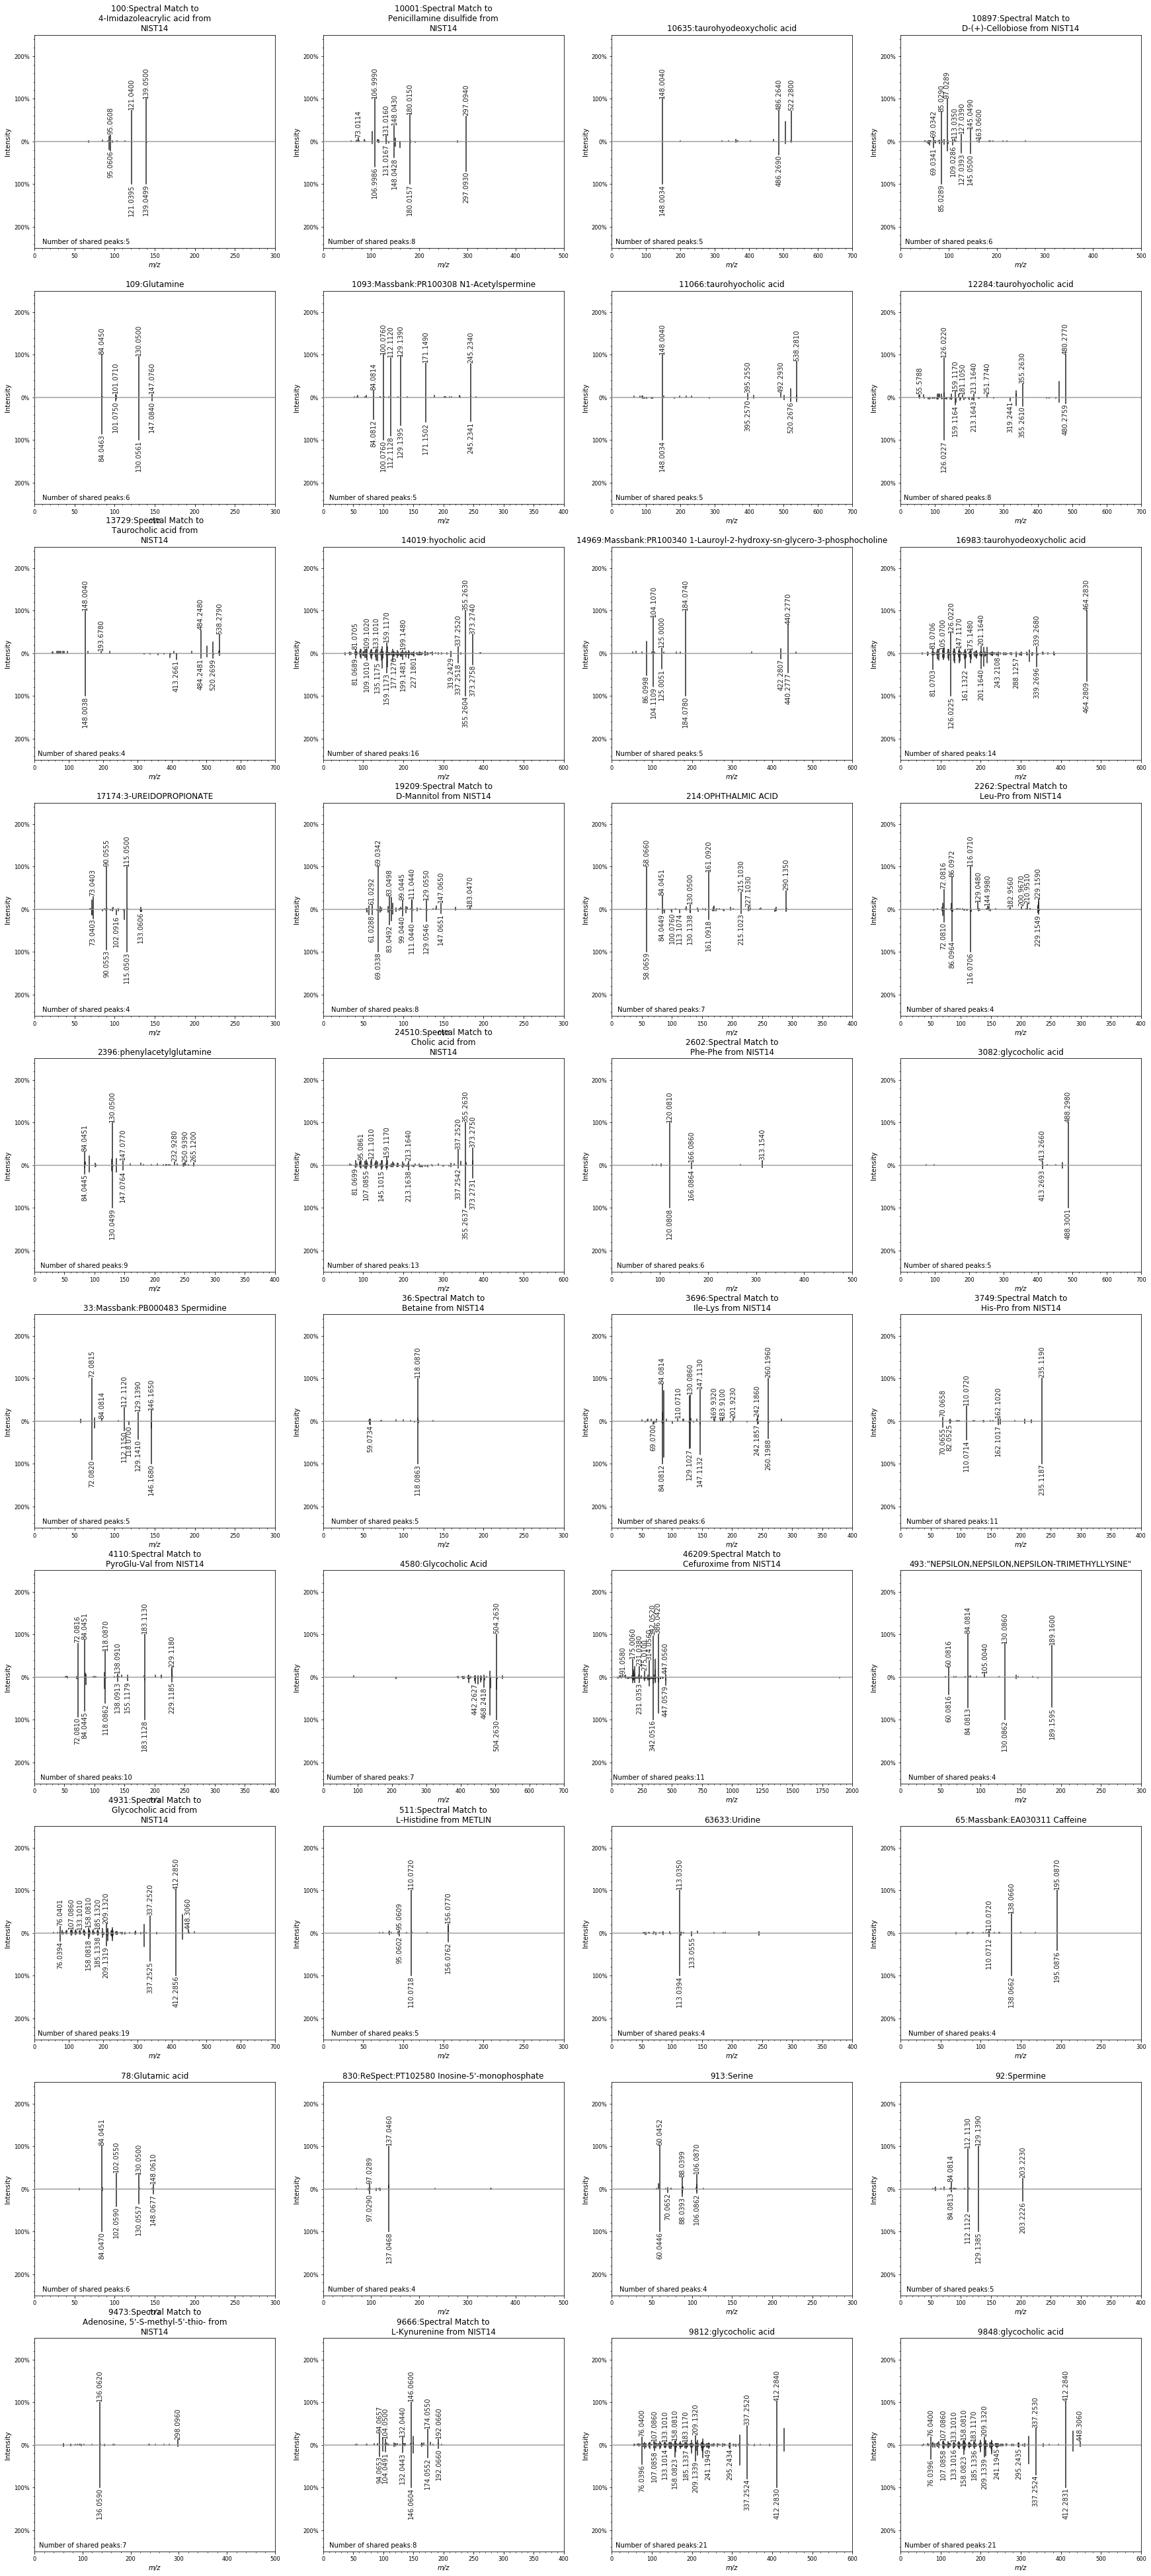

In [23]:
fig, axes = plt.subplots(10, 4, sharex=False, sharey=False)
fig.set_figheight(70) #12
fig.set_figwidth(30) #60

# axes are in a two-dimensional array, indexed by [row, col]
ind = 0
for i in range(10):
    for j in range(4):
        
        ax = axes[i, j] 
        
        ax.annotate('Number of shared peaks:%s' % (int(sharedpeaks[ind])), xy =(10, -2.4))

        spectrum_plotter_plot.mirror(specs1[ind], specs2[ind], ax=ax, spectrum_kws = {'grid':False})
        title = f'{clindexes[ind]}:{pretty_name(cn[ind])}'
        ax.set_title(title)
        ind = ind+1

        xmin, xmax = ax.get_xlim()
        ax.set_xlim(kwargs.get('xmin', xmin), kwargs.get('xmax', xmax))
        if kwargs.get('label', False):
            ax.set_ylim(-2.5, 2.5)

fig

In [24]:
fig.savefig('MirrorPlots.pdf')